# Étude progressive des réseaux de neurones sur le jeu de données HAR - Partie 1

## Importation des packages 

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder


torch.manual_seed(0)
np.random.seed(0)

## Partie 1 : Jeu de données

### 1.1. Chargement et aperçu des données

In [2]:
train = pd.read_csv("./HAR/train.csv")

In [3]:
print(f"Train shape : {train.shape}")

# Aperçu des données
display(train.head())
print("\nColonnes disponibles :")
print(list(train.columns[:10]), "...")

# La variable cible
print("\nValeurs uniques dans la colonne 'Activity' :")
print(train['Activity'].unique())

Train shape : (7352, 563)


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING



Colonnes disponibles :
['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X'] ...

Valeurs uniques dans la colonne 'Activity' :
['STANDING' 'SITTING' 'LAYING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']


### 1.2. Analyse Exploratoire des données (EDA)

In [6]:
# Nombre de classes
print(f"\nNombre de classes d'activité : {train['Activity'].nunique()}")


Nombre de classes d'activité : 6


C:\Users\dkone2\AppData\Local\Temp\ipykernel_10000\2862901555.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=train['Activity'], order=train['Activity'].value_counts().index, palette="viridis")


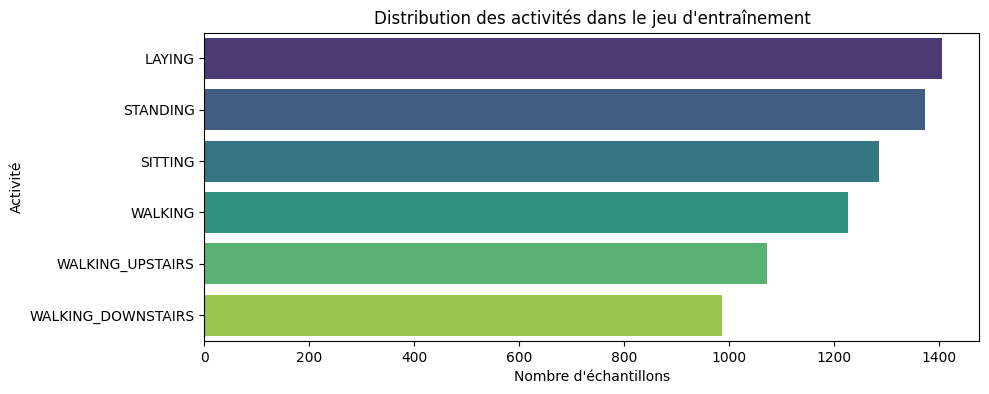

In [7]:
# Distribution des classes
plt.figure(figsize=(10,4))
sns.countplot(y=train['Activity'], order=train['Activity'].value_counts().index, palette="viridis")
plt.title("Distribution des activités dans le jeu d'entraînement")
plt.xlabel("Nombre d'échantillons")
plt.ylabel("Activité")
plt.show()

In [8]:
# Vérification des valeurs manquantes
print("\nValeurs manquantes dans le jeu d'entraînement :")
print(train.isnull().sum().sum())


Valeurs manquantes dans le jeu d'entraînement :
0


In [9]:
# Statistiques descriptives 
stats = train.describe().T[['mean', 'std', 'min', 'max']]
display(stats.head(10))

print(f"\nNombre total de variables numériques : {stats.shape[0]}")

,mean,std,min,max
tBodyAcc-mean()-X,0.274488,0.070261,-1.000000,1.000000
tBodyAcc-mean()-Y,-0.017695,0.040811,-1.000000,1.000000
tBodyAcc-mean()-Z,-0.109141,0.056635,-1.000000,1.000000
tBodyAcc-std()-X,-0.605438,0.448734,-1.000000,1.000000
tBodyAcc-std()-Y,-0.510938,0.502645,-0.999873,0.916238
tBodyAcc-std()-Z,-0.604754,0.418687,-1.000000,1.000000
tBodyAcc-mad()-X,-0.630512,0.424073,-1.000000,1.000000
tBodyAcc-mad()-Y,-0.526907,0.485942,-1.000000,0.967664
tBodyAcc-mad()-Z,-0.606150,0.414122,-1.000000,1.000000
tBodyAcc-max()-X,-0.468604,0.544547,-1.000000,1.000000



Nombre total de variables numériques : 562


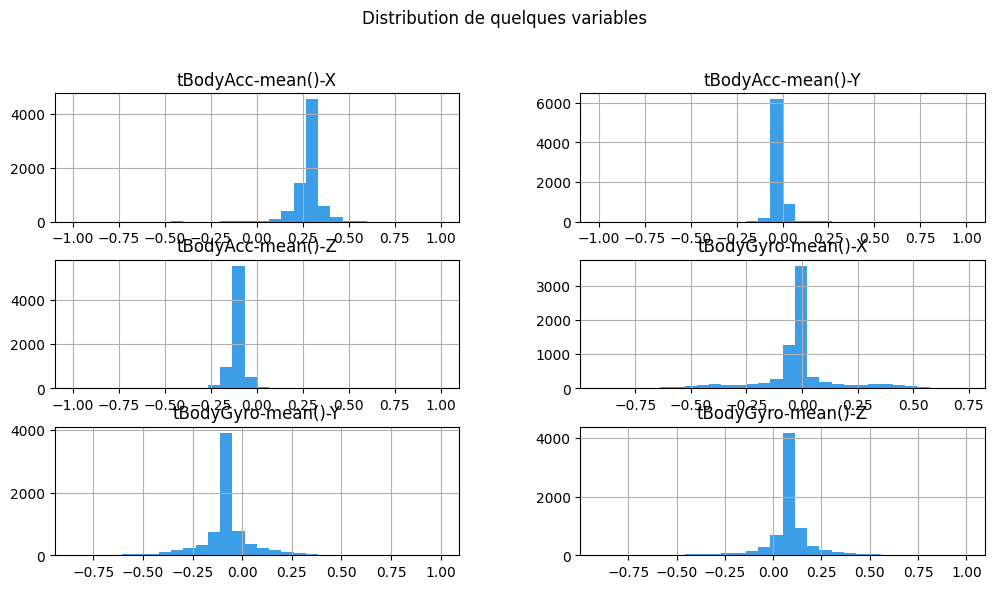

In [9]:
# Histogrammes de quelques variables

sample_cols = ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyGyro-mean()-X', 'tBodyGyro-mean()-Y', 'tBodyGyro-mean()-Z']

train[sample_cols].hist(bins=30, figsize=(12, 6), color='#3C9EE7')
plt.suptitle("Distribution de quelques variables", y=1.02)
plt.show()

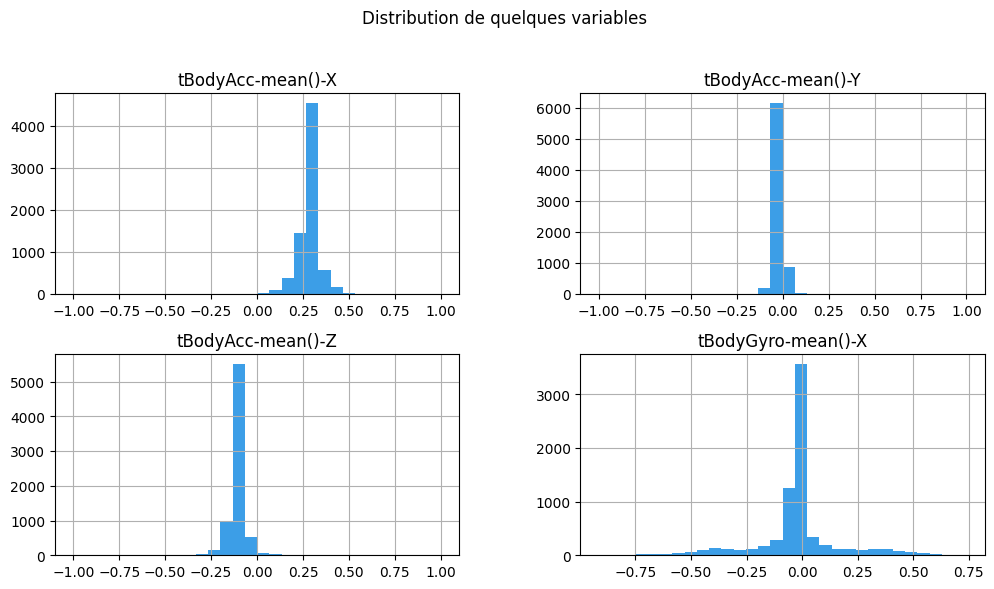

In [10]:
# Histogrammes de quelques variables

sample_cols = ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyGyro-mean()-X']

train[sample_cols].hist(bins=30, figsize=(12, 6), color='#3C9EE7')
plt.suptitle("Distribution de quelques variables", y=1.02)
plt.show()

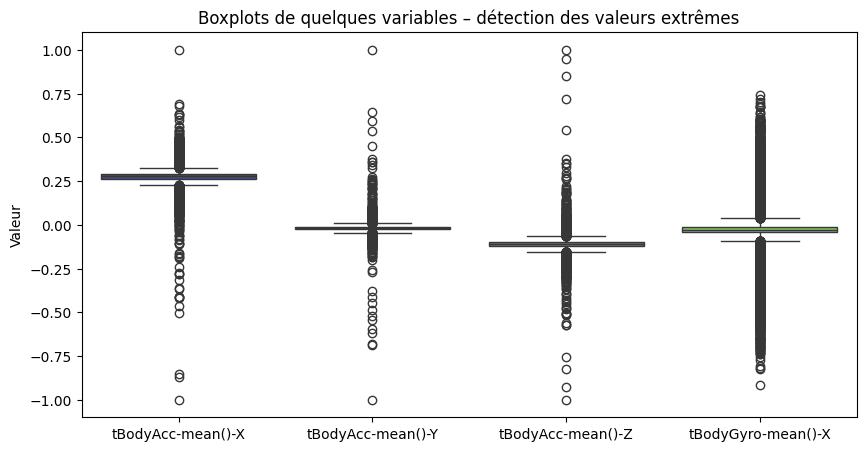

In [11]:
# Boxplots pour détecter les valeurs extrêmes

plt.figure(figsize=(10, 5))
sns.boxplot(data=train[sample_cols], palette="viridis")
plt.title("Boxplots de quelques variables – détection des valeurs extrêmes")
plt.ylabel("Valeur")
plt.show()

In [11]:
# Corrélations entre variables

corr_matrix = train.drop(columns=['subject', 'Activity']).corr()

corr_sample = corr_matrix.abs().unstack().sort_values(ascending=False)
corr_sample = corr_sample[corr_sample < 1.0].drop_duplicates().head(15)

print(corr_sample)

fBodyAccJerk-energy()-Z         tBodyAccJerk-energy()-Z          1.000000
tBodyAccJerk-energy()-Y         fBodyAccJerk-energy()-Y          1.000000
fBodyAccJerk-energy()-X         tBodyAccJerk-energy()-X          0.999999
fBodyAcc-bandsEnergy()-1,24     fBodyAcc-energy()-X              0.999878
fBodyGyro-bandsEnergy()-1,24    fBodyGyro-energy()-X             0.999767
fBodyAcc-energy()-Y             fBodyAcc-bandsEnergy()-1,24.1    0.999661
tBodyAccJerkMag-sma()           tBodyAccJerk-sma()               0.999656
tBodyAcc-energy()-X             fBodyAcc-energy()-X              0.999611
fBodyGyro-bandsEnergy()-1,24.2  fBodyGyro-energy()-Z             0.999523
tBodyAcc-energy()-X             fBodyAcc-bandsEnergy()-1,24      0.999507
tBodyGyro-energy()-Y            fBodyGyro-energy()-Y             0.999242
tBodyGyroMag-mean()             tBodyGyro-sma()                  0.999234
tBodyAcc-sma()                  tBodyAccMag-sma()                0.999111
fBodyAcc-bandsEnergy()-1,16     fBodyA

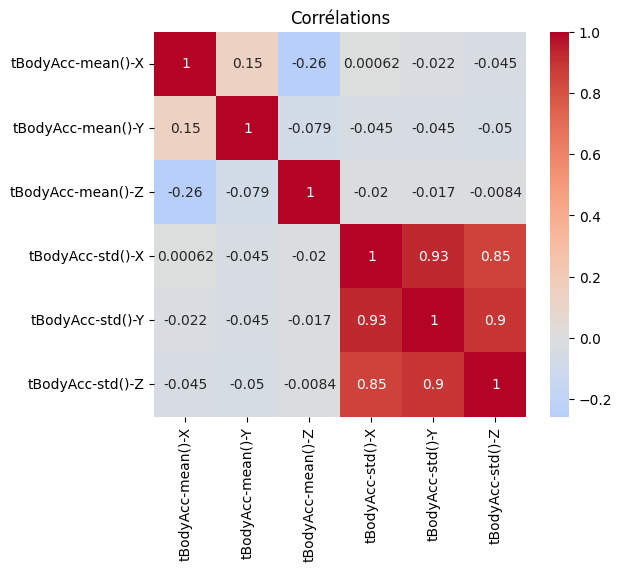

In [12]:
# Visualisation de la corrélation 
subset_cols = [
    'tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
    'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z'
]

plt.figure(figsize=(6, 5))
sns.heatmap(train[subset_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Corrélations")
plt.show()

L'analyse exploratoire montre que le dataset ne contient pas de données manquantes et ne nécessite pas de nettoyage complexe. Un encodage de la cible et une normalisation sont à prévoir avant l’apprentissage. 

## Partie 2 : Première architecture de réseau

In [14]:
# Encodage de la variable cible 'Activity'

# Encodage des labels
label_encoder = LabelEncoder()
train['Activity_encoded'] = label_encoder.fit_transform(train['Activity'])

In [15]:
# Vérification
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Mapping des classes :")
print(label_mapping)

Mapping des classes :
{'LAYING': np.int64(0), 'SITTING': np.int64(1), 'STANDING': np.int64(2), 'WALKING': np.int64(3), 'WALKING_DOWNSTAIRS': np.int64(4), 'WALKING_UPSTAIRS': np.int64(5)}


In [16]:
# Séparation des colonnes explicatives (X) et la variable cible (y)

X_train = train.drop(columns=['Activity', 'Activity_encoded', 'subject'])
y_train = train['Activity_encoded']

print(f"Dimensions des features (train) : {X_train.shape}")
print(f"Dimensions des labels   (train) : {y_train.shape}")

Dimensions des features (train) : (7352, 561)
Dimensions des labels   (train) : (7352,)


In [18]:
# Séparation en jeu d'entrainement et de validation

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

In [19]:
# Standardisation des variables

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

print("Aperçu après standardisation :")
print(X_train_scaled[:3, :5])

Aperçu après standardisation :
[[ 0.0484155  -0.00190694  0.0042624  -0.86909332 -0.96650283]
 [-0.52681746  0.39917214 -0.09072664  0.61910154  1.15388967]
 [ 0.23238315 -0.78128154  0.61522408  1.28760696  0.95106806]]


In [20]:
# Conversion en tenseurs PyTorch

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

X_valid_tensor = torch.tensor(X_valid_scaled, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.long)
 
print(f"Tensor features (train) : {X_train_tensor.shape}")
print(f"Tensor labels   (train) : {y_train_tensor.shape}")

Tensor features (train) : torch.Size([5881, 561])
Tensor labels   (train) : torch.Size([5881])


In [21]:
# Création des DataLoaders

batch_size = 64

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset  = TensorDataset(X_valid_tensor, y_valid_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader  = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

print(f"Nombre de batchs d'entraînement : {len(train_loader)}")
print(f"Nombre de batchs de validation        : {len(valid_loader)}")

Nombre de batchs d'entraînement : 92
Nombre de batchs de validation        : 23


In [22]:
# Vérification d’un mini-batch
for X_batch, y_batch in train_loader:
    print(f"Batch X : {X_batch.shape}, Batch y : {y_batch.shape}")
    break

Batch X : torch.Size([64, 561]), Batch y : torch.Size([64])


In [23]:
# Mise en place du réseau MLP simple

class MLP_1Hidden(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation="relu"):
        super(MLP_1Hidden, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        # Choix de la fonction d’activation
        if activation == "relu":
            self.activation = nn.ReLU()
        elif activation == "sigmoid":
            self.activation = nn.Sigmoid()
        elif activation == "tanh":
            self.activation = nn.Tanh()
        else:
            raise ValueError("Activation non reconnue. Choisir parmi 'relu', 'sigmoid', 'tanh'.")
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)  
        return x

In [24]:
# Initialisation du modèle, de la loss et de l’optimiseur

input_dim = X_train_tensor.shape[1]
hidden_dim = 64
output_dim = len(label_encoder.classes_)

# Exemple avec ReLU et Adam
model = MLP_1Hidden(input_dim, hidden_dim, output_dim, activation="relu")

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(model)

MLP_1Hidden(
  (fc1): Linear(in_features=561, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=6, bias=True)
  (activation): ReLU()
)


In [25]:
# Fonction d’entraînement et d’évaluation

def train_model(model, criterion, optimizer, train_loader, test_loader, epochs=30, device='cpu'):
    model.to(device)
    history = {"train_loss": [], "test_loss": [], "train_acc": [], "test_acc": [], "f1_macro": []}
    
    for epoch in range(epochs):
        # Entraînement 
        model.train()
        running_loss, running_correct = 0.0, 0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * X_batch.size(0)
            preds = outputs.argmax(1)
            running_correct += (preds == y_batch).sum().item()
        
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = running_correct / len(train_loader.dataset)
        
        # Evaluation 
        model.eval()
        test_loss, test_correct = 0.0, 0
        y_true, y_pred = [], []
        
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item() * X_batch.size(0)
                preds = outputs.argmax(1)
                test_correct += (preds == y_batch).sum().item()
                y_true.extend(y_batch.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
        
        test_loss /= len(test_loader.dataset)
        test_acc = test_correct / len(test_loader.dataset)
        f1_macro = f1_score(y_true, y_pred, average='macro')
        
        # Sauvegarde
        history["train_loss"].append(train_loss)
        history["test_loss"].append(test_loss)
        history["train_acc"].append(train_acc)
        history["test_acc"].append(test_acc)
        history["f1_macro"].append(f1_macro)
        
        print(f"Epoch [{epoch+1}/{epochs}]  "
              f"Train Loss: {train_loss:.4f}  Test Loss: {test_loss:.4f}  "
              f"Train Acc: {train_acc:.4f}  Test Acc: {test_acc:.4f}  F1: {f1_macro:.4f}")
    
    return history

In [29]:
# Entraînement du modèle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
history_relu_adam = train_model(model, criterion, optimizer, train_loader, valid_loader, epochs=30, device=device)

Epoch [1/30]  Train Loss: 0.1489  Test Loss: 0.1407  Train Acc: 0.9537  Test Acc: 0.9497  F1: 0.9516
Epoch [2/30]  Train Loss: 0.1020  Test Loss: 0.1066  Train Acc: 0.9680  Test Acc: 0.9646  F1: 0.9660
Epoch [3/30]  Train Loss: 0.0768  Test Loss: 0.0911  Train Acc: 0.9730  Test Acc: 0.9680  F1: 0.9696
Epoch [4/30]  Train Loss: 0.0623  Test Loss: 0.0799  Train Acc: 0.9787  Test Acc: 0.9714  F1: 0.9728
Epoch [5/30]  Train Loss: 0.0558  Test Loss: 0.0825  Train Acc: 0.9823  Test Acc: 0.9728  F1: 0.9740
Epoch [6/30]  Train Loss: 0.0528  Test Loss: 0.0724  Train Acc: 0.9811  Test Acc: 0.9776  F1: 0.9784
Epoch [7/30]  Train Loss: 0.0458  Test Loss: 0.0721  Train Acc: 0.9855  Test Acc: 0.9755  F1: 0.9765
Epoch [8/30]  Train Loss: 0.0465  Test Loss: 0.0651  Train Acc: 0.9827  Test Acc: 0.9769  F1: 0.9779
Epoch [9/30]  Train Loss: 0.0434  Test Loss: 0.0772  Train Acc: 0.9833  Test Acc: 0.9660  F1: 0.9678
Epoch [10/30]  Train Loss: 0.0376  Test Loss: 0.0616  Train Acc: 0.9874  Test Acc: 0.9782  

In [38]:
# Visualisation des métriques

def plot_history(history, title="Historique d'entraînement"):
    plt.figure(figsize=(12,5))
    
    # Loss
    plt.subplot(1,2,1)
    plt.plot(history["train_loss"], label="Train")
    plt.plot(history["test_loss"], label="Validate")
    plt.title("Loss")
    plt.xlabel("Époque")
    plt.ylabel("Valeur")
    plt.legend()
    
    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(history["train_acc"], label="Train")
    plt.plot(history["test_acc"], label="Validate")
    plt.title("Accuracy")
    plt.xlabel("Époque")
    plt.ylabel("Score")
    plt.legend()
    
    plt.suptitle(title)
    plt.show()

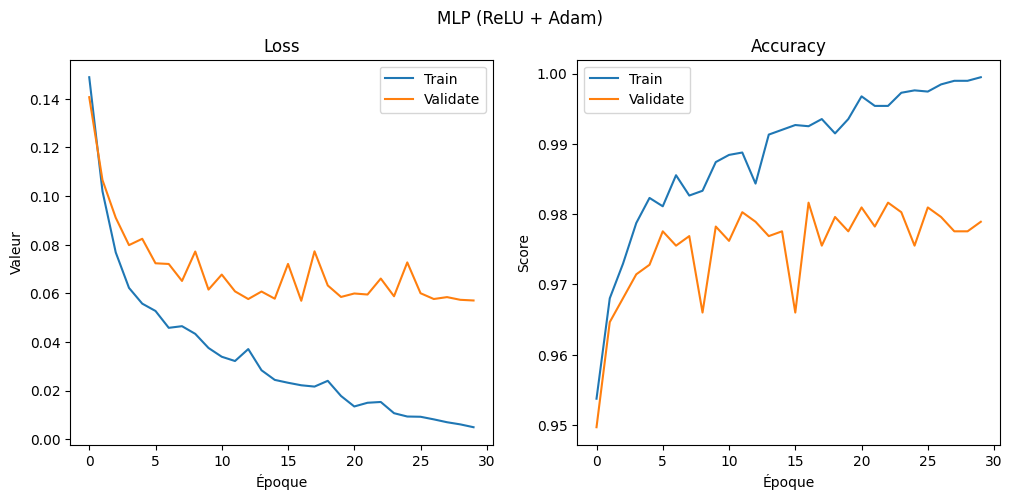

In [39]:
plot_history(history_relu_adam, title="MLP (ReLU + Adam)")

### Variation des optimiseurs et fonctions d'activation

In [33]:
# Entraînement avec plusieurs fonctions d’activation et optimiseurs

activations = ["relu", "sigmoid", "tanh"]
optimizers = ["adam", "sgd", "sgd_momentum"]

results = {}  

for act in activations:
    for opt_name in optimizers:
        print("="*70)
        print(f" Entraînement avec activation = {act.upper()} | optimiseur = {opt_name.upper()}")
   
        model = MLP_1Hidden(input_dim, hidden_dim, output_dim, activation=act)
        
        if opt_name == "adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        elif opt_name == "sgd":
            optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
        elif opt_name == "sgd_momentum":
            optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
        
        history = train_model(model, criterion, optimizer, train_loader, valid_loader, epochs=30, device=device)
        
        results[(act, opt_name)] = history

 Entraînement avec activation = RELU | optimiseur = ADAM
Epoch [1/30]  Train Loss: 0.4532  Test Loss: 0.2310  Train Acc: 0.8573  Test Acc: 0.9252  F1: 0.9256
Epoch [2/30]  Train Loss: 0.1512  Test Loss: 0.1373  Train Acc: 0.9515  Test Acc: 0.9599  F1: 0.9608
Epoch [3/30]  Train Loss: 0.1025  Test Loss: 0.1414  Train Acc: 0.9679  Test Acc: 0.9463  F1: 0.9488
Epoch [4/30]  Train Loss: 0.0818  Test Loss: 0.0964  Train Acc: 0.9706  Test Acc: 0.9660  F1: 0.9677
Epoch [5/30]  Train Loss: 0.0677  Test Loss: 0.0935  Train Acc: 0.9750  Test Acc: 0.9613  F1: 0.9633
Epoch [6/30]  Train Loss: 0.0619  Test Loss: 0.0810  Train Acc: 0.9782  Test Acc: 0.9714  F1: 0.9726
Epoch [7/30]  Train Loss: 0.0522  Test Loss: 0.0966  Train Acc: 0.9827  Test Acc: 0.9626  F1: 0.9648
Epoch [8/30]  Train Loss: 0.0461  Test Loss: 0.0685  Train Acc: 0.9827  Test Acc: 0.9762  F1: 0.9771
Epoch [9/30]  Train Loss: 0.0431  Test Loss: 0.0657  Train Acc: 0.9854  Test Acc: 0.9776  F1: 0.9785
Epoch [10/30]  Train Loss: 0.0395 

In [40]:
summary = []
for (act, opt), hist in results.items():
    best_epoch = np.argmax(hist["test_acc"])
    summary.append({
        "Activation": act,
        "Optimiseur": opt,
        "Best Epoch": best_epoch+1,
        "Train Acc": hist["train_acc"][best_epoch],
        "Validate Acc": hist["test_acc"][best_epoch],
        "F1 Macro": hist["f1_macro"][best_epoch],
        "Validate Loss": hist["test_loss"][best_epoch]
    })

df_summary = pd.DataFrame(summary)
display(df_summary.sort_values(by="Validate Acc", ascending=False))

,Activation,Optimiseur,Best Epoch,Train Acc,Validate Acc,F1 Macro,Validate Loss
6,tanh,adam,30,0.999660,0.985044,0.985438,0.053597
0,relu,adam,26,0.997279,0.984364,0.984933,0.054242
3,sigmoid,adam,28,0.994559,0.983005,0.983828,0.052580
8,tanh,sgd_momentum,19,0.993539,0.982325,0.982827,0.057274
2,relu,sgd_momentum,26,0.989628,0.981645,0.982202,0.059347
5,sigmoid,sgd_momentum,27,0.986907,0.976207,0.976897,0.074008
1,relu,sgd,29,0.982656,0.972128,0.973200,0.089549
7,tanh,sgd,30,0.981976,0.972128,0.973046,0.095045
4,sigmoid,sgd,29,0.941847,0.937458,0.937845,0.241193


In [41]:
# Visualisation des métriques pour chaque couple

def plot_all_results(results_dict, metric="loss"):
    n_rows = len(activations)
    n_cols = len(optimizers)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    
    for i, act in enumerate(activations):
        for j, opt in enumerate(optimizers):
            ax = axes[i, j] if n_rows > 1 else axes[j]
            hist = results_dict[(act, opt)]
            
            if metric == "loss":
                ax.plot(hist["train_loss"], label="Train Loss")
                ax.plot(hist["test_loss"], label="Validate Loss")
                ax.set_ylabel("Loss")
            elif metric == "accuracy":
                ax.plot(hist["train_acc"], label="Train Acc")
                ax.plot(hist["test_acc"], label="Validate Acc")
                ax.set_ylabel("Accuracy")
            
            ax.set_title(f"{act.upper()} + {opt.upper()}")
            ax.set_xlabel("Époques")
            ax.legend()
            ax.grid(True, linestyle="--", alpha=0.5)
    
    plt.suptitle(f"Évolution {metric.capitalize()} – Train vs Validate", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

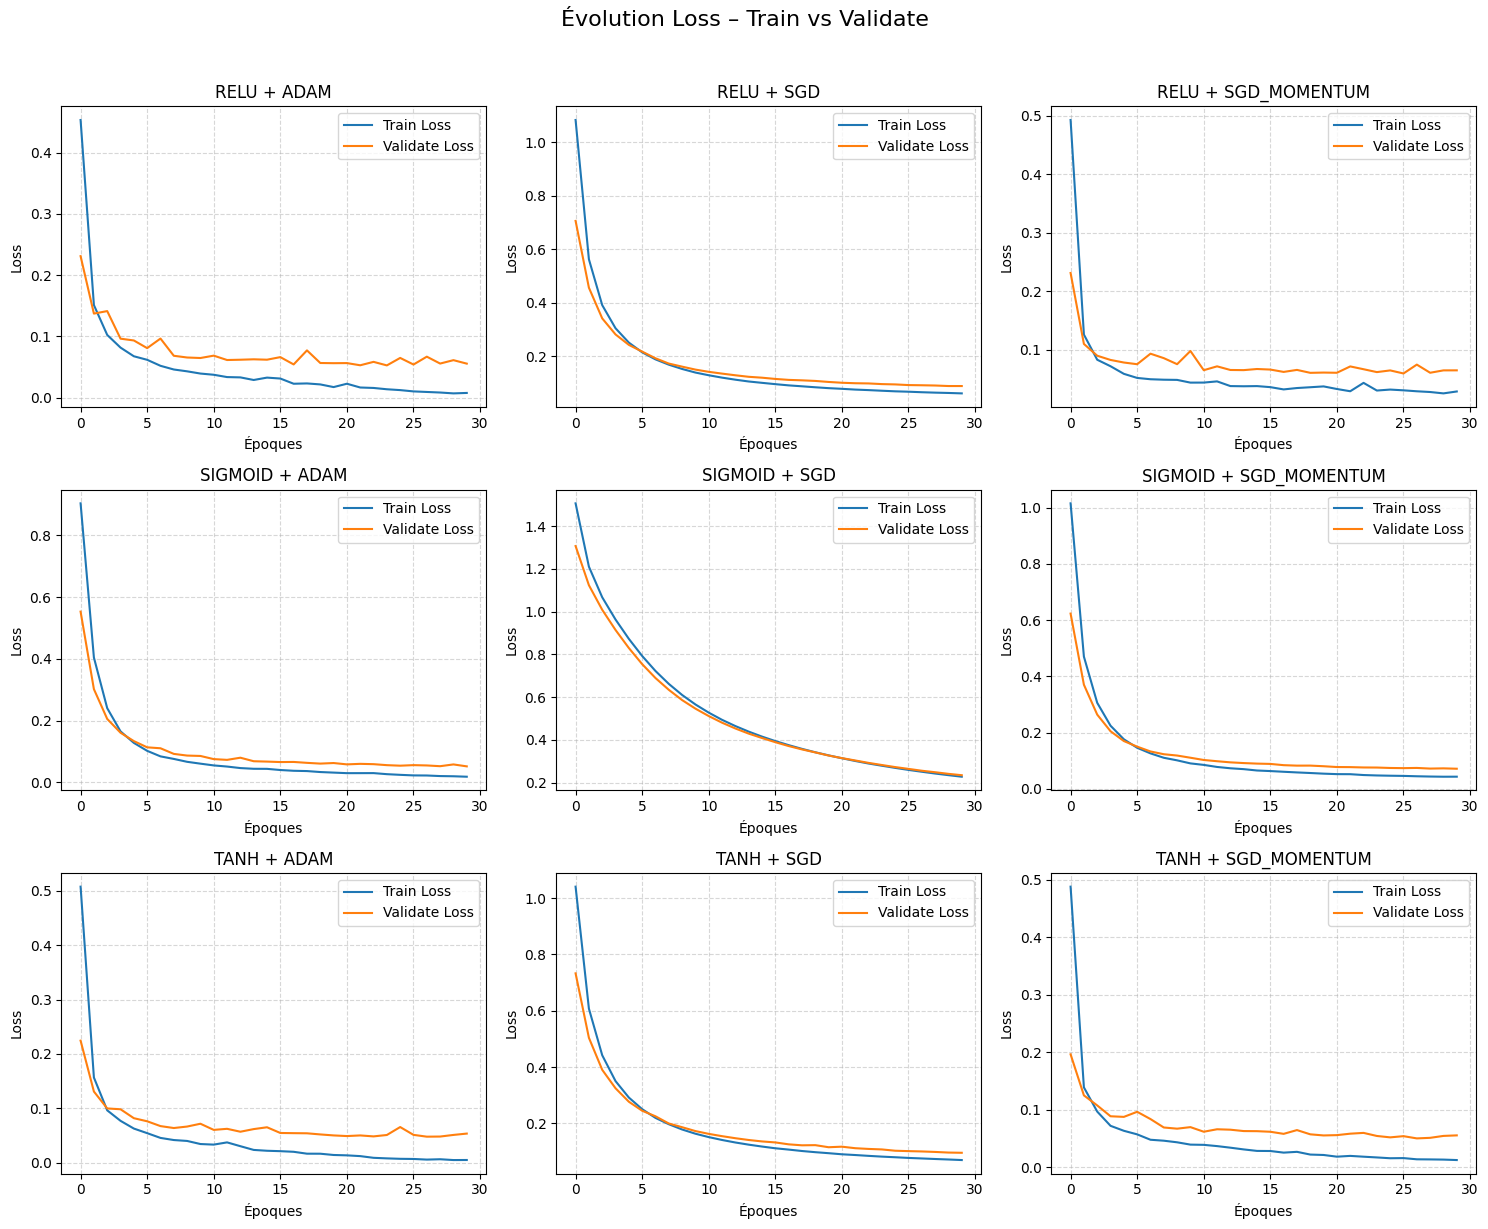

In [42]:
plot_all_results(results, metric="loss")

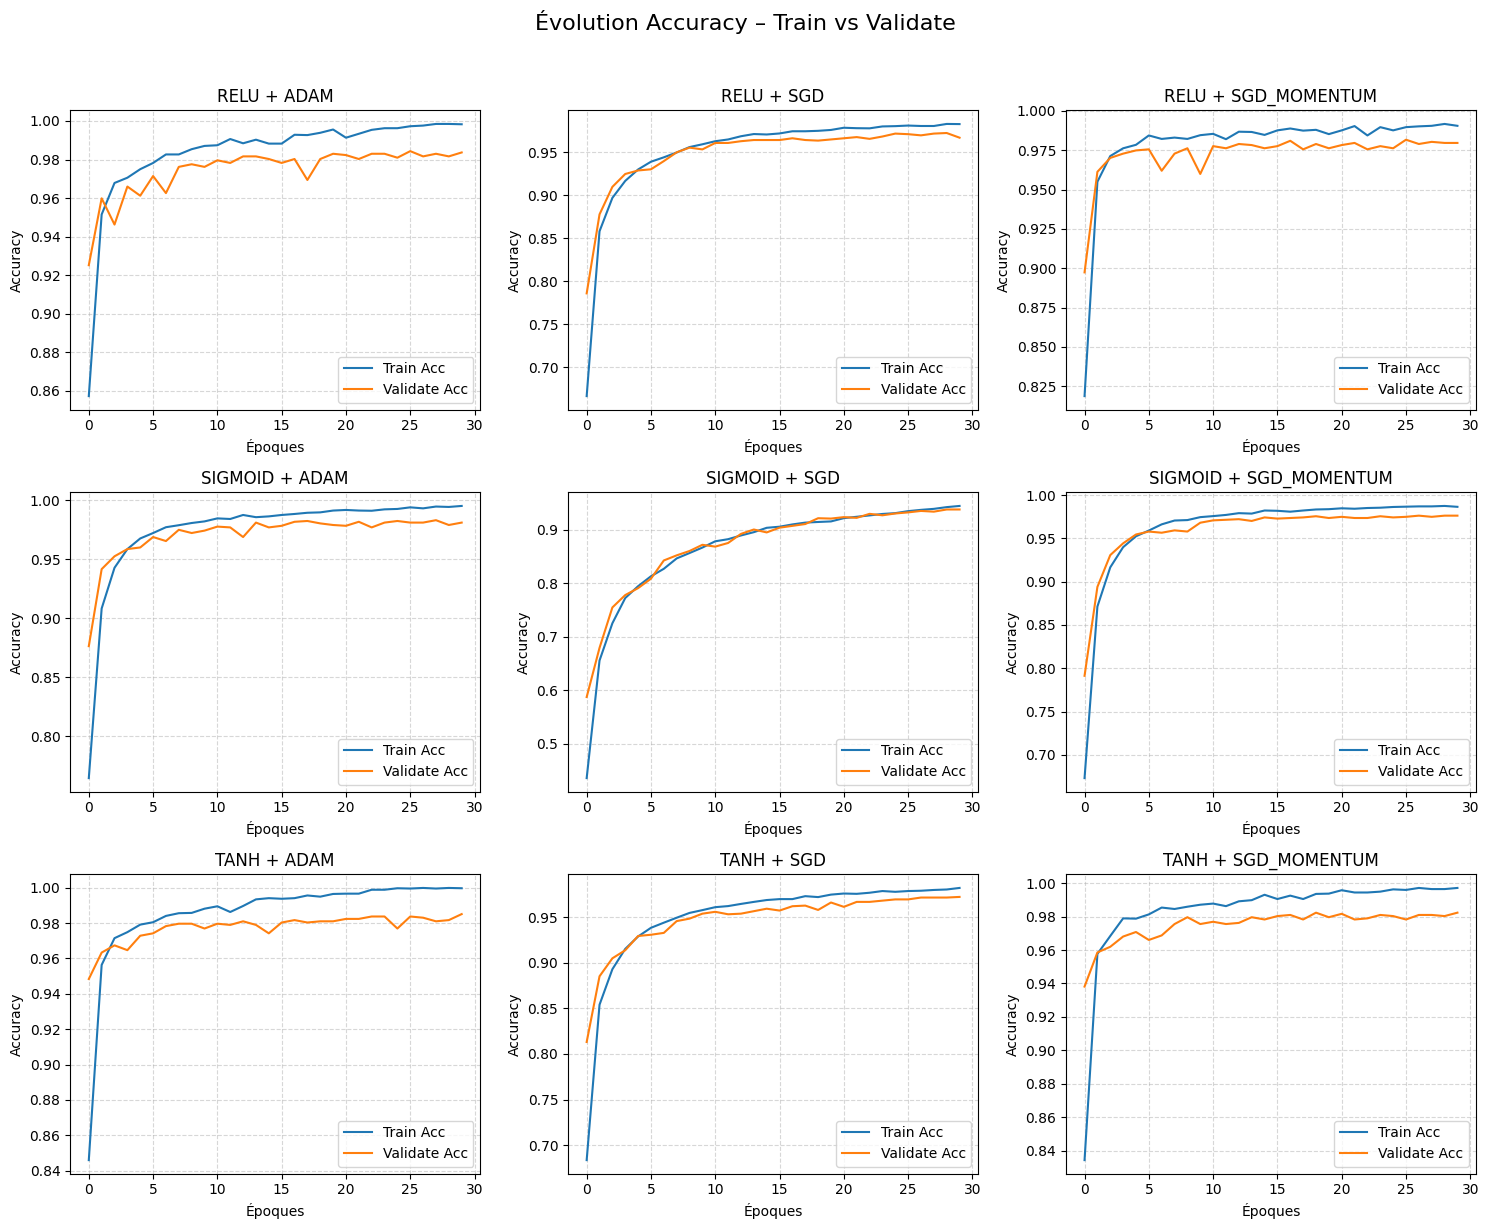

In [43]:
plot_all_results(results, metric="accuracy")

- On observe tout d’abord que, pour l’ensemble des expériences, le modèle converge rapidement : la précision d’entraînement atteint presque 100 % après une dizaine d’époques. Cependant, la précision sur le jeu de validation se stabilise autour de 92 % à 96 %, ce qui indique une bonne capacité d’apprentissage, mais aussi un surapprentissage.

- Les courbes de loss confirment cette observation : la perte d’entraînement diminue fortement pour tendre vers zéro, tandis que les pertes de la validation restent plus élevées et plus fluctuantes. Cela suggère que les modèle s’adapte un peu trop au jeu d’entraînement et a du mal avec les nouvelles données (de validation). 

- ReLU et Tanh se démarque un peu comme la fonction la plus efficace : elle permet une convergence rapide et stable et conduit aux meilleures précisions en particulier lorsqu’elle est associée à Adam ou SGD avec momentum. Mais ReLU et Tanh laisse voir un léger surapprentissage.

- Sigmoid présente la convergence la plus lente et atteint des performances légèrement inférieures mais s'adapte très bien avec une bonne généralisation.

- Pour conclure, les résultats montrent de bons compromis entre rapidité d’apprentissage, stabilité et généralisation. Le léger écart entre accuracy train et validation met en évidence un surapprentissage, qu’il serait possible de réduire grâce à des techniques de régularisation telles que le dropout, la batch normalization, ou l’early stopping.